In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import ast
from wordcloud import WordCloud

In [261]:
import CleanTweets as ct

In [79]:
def get_wordcloud(df, text_col):# Generate a word cloud image
    wordcloud = WordCloud(background_color="white", width=1500, height=800).generate(' '.join(df[text_col]))

    # Display the generated image:

    plt.figure(figsize=(18,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [264]:
def draw_network(df, text_col, max_similarity):
    
    cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english') # You can define your own parameters
    X = cv.fit_transform(df[text_col])
    Xc = (X.T * X) # Cosine similarity of words

    names = cv.get_feature_names() # This are the entity names (i.e. keywords)
    df_co = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)

    a = df_co.stack().reset_index()
    a.columns = ['source', 'target','value']
    a_filtered=a.loc[ (a['value'] > max_similarity) & (a['source'] != a['target']) ]


    # Build your graph
    plt.figure(figsize=(20,10))
    G=nx.from_pandas_edgelist(a_filtered, 'source', 'target')

    # Plot the network:
    # pos = graphviz_layout(G)
    nx.draw(G, with_labels=True, node_color='orange', node_size=50, edge_color='green', linewidths=2, font_size=15)

# Publications

### 1. Time/volume - line chart

In [136]:
df = pd.read_csv('bb_pulications.csv', index_col=0)

In [152]:
df['pub_year'] = df['bib'].apply(lambda x: ast.literal_eval(x)['pub_year'])
df_not_nan = df[df['pub_year']!= 'NA']

Note we lose a couple of publications because a number of them do not have publication year attached

In [205]:
#df_not_nan['pub_year'] = pd.to_datetime(df_not_nan['pub_year'])
df_not_nan['pub_year'] = df_not_nan['pub_year'].astype(int)
df_groupedby_date = df_not_nan.groupby('pub_year').count()
df_groupedby_date.reset_index(inplace=True)

<ipython-input-205-9457200de1e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_nan['pub_year'] = df_not_nan['pub_year'].astype(int)


In [206]:
df_groupedby_date['count'] = df_groupedby_date['container_type']

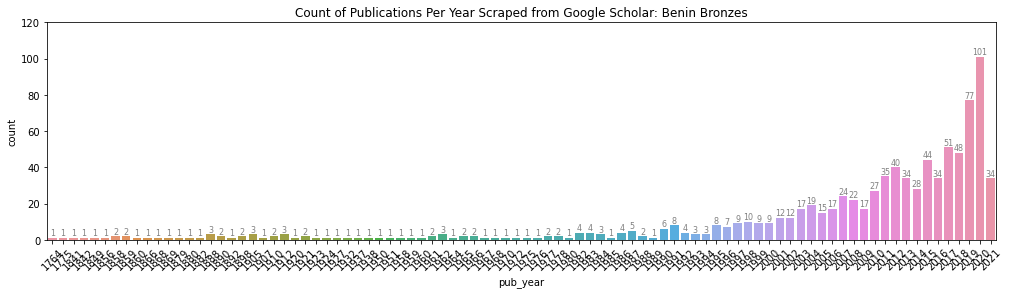

In [237]:
plt.figure(figsize=[17,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Scraped from Google Scholar: Benin Bronzes')
g = sns.barplot(data=df_groupedby_date, 
             x="pub_year", 
             y="count") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,120) #To make space for the annotations

In [212]:
df_groupedby_date_2016 = df_groupedby_date[df_groupedby_date['pub_year'] > 2015]

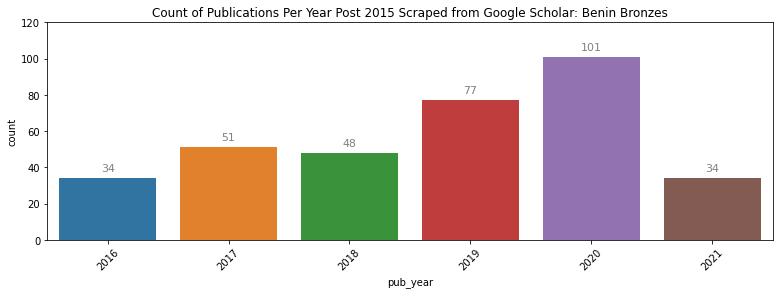

In [238]:
plt.figure(figsize=[13,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Post 2015 Scraped from Google Scholar: Benin Bronzes')
g = sns.barplot(data=df_groupedby_date_2016, 
             x="pub_year", 
             y="count")
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
_ = ax.set_ylim(0,120) #To make space for the annotations

### 2. Keywords - Network diagram

In [250]:
def get_abstract(x):
    try:
        return ast.literal_eval(x)['abstract']
    except KeyError:
        return ''

In [257]:
df['abstract'] = df['bib'].apply(lambda x: get_abstract(x) )
df_abs = df[df['abstract']!= '']

We lose around 100 publications because they do not have abstracts

In [262]:
df_abs = ct.clean_tweets(df_abs,'abstract','lemma_text',
                general_clean=True,lemma=True,stem=False,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 7.827116012573242s. Use the [lemma_text] column to perform your analysis/modeling on


In [263]:
df_abs = ct.clean_tweets(df_abs,'abstract','stem_text',
                general_clean=True,lemma=False,stem=True,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 1.1630818843841553s. Use the [stem_text] column to perform your analysis/modeling on


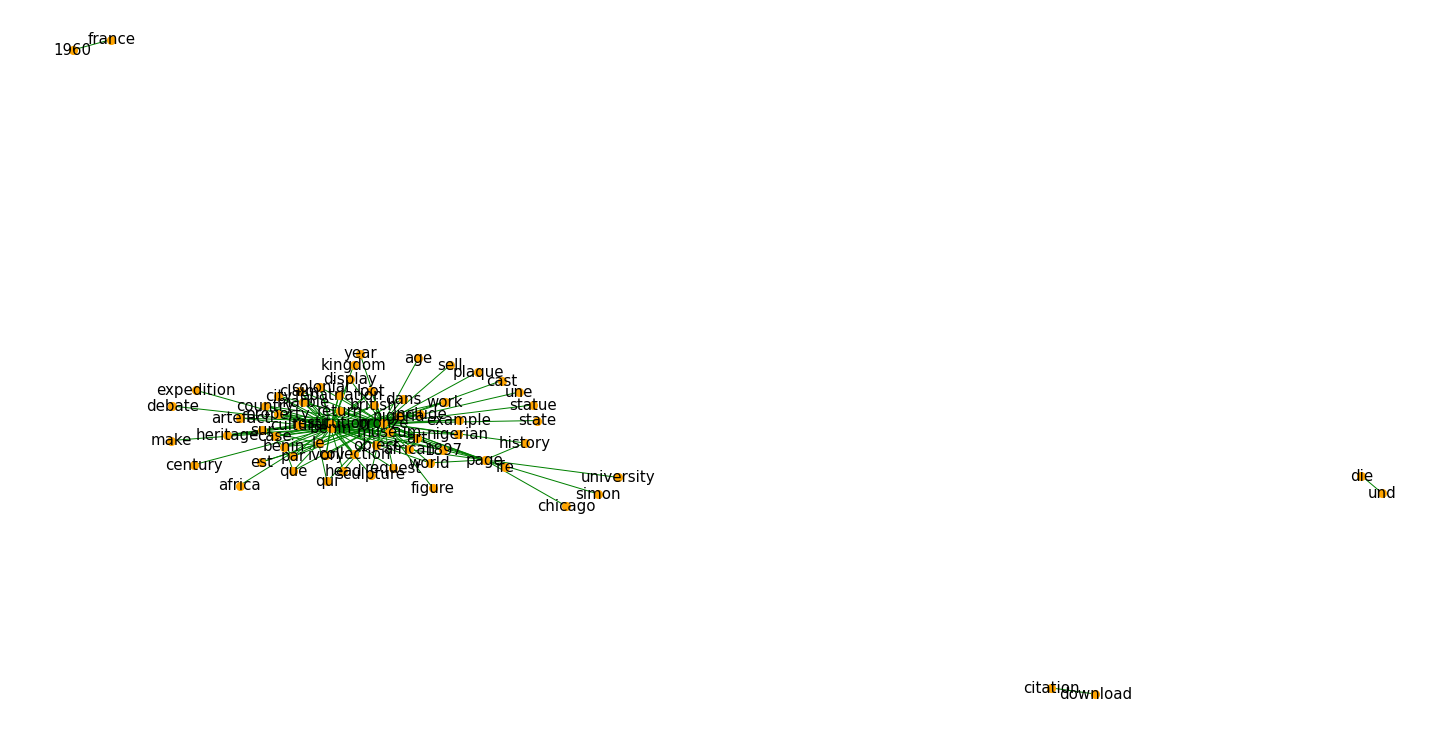

In [268]:
draw_network(df_abs, 'lemma_text', 30) 

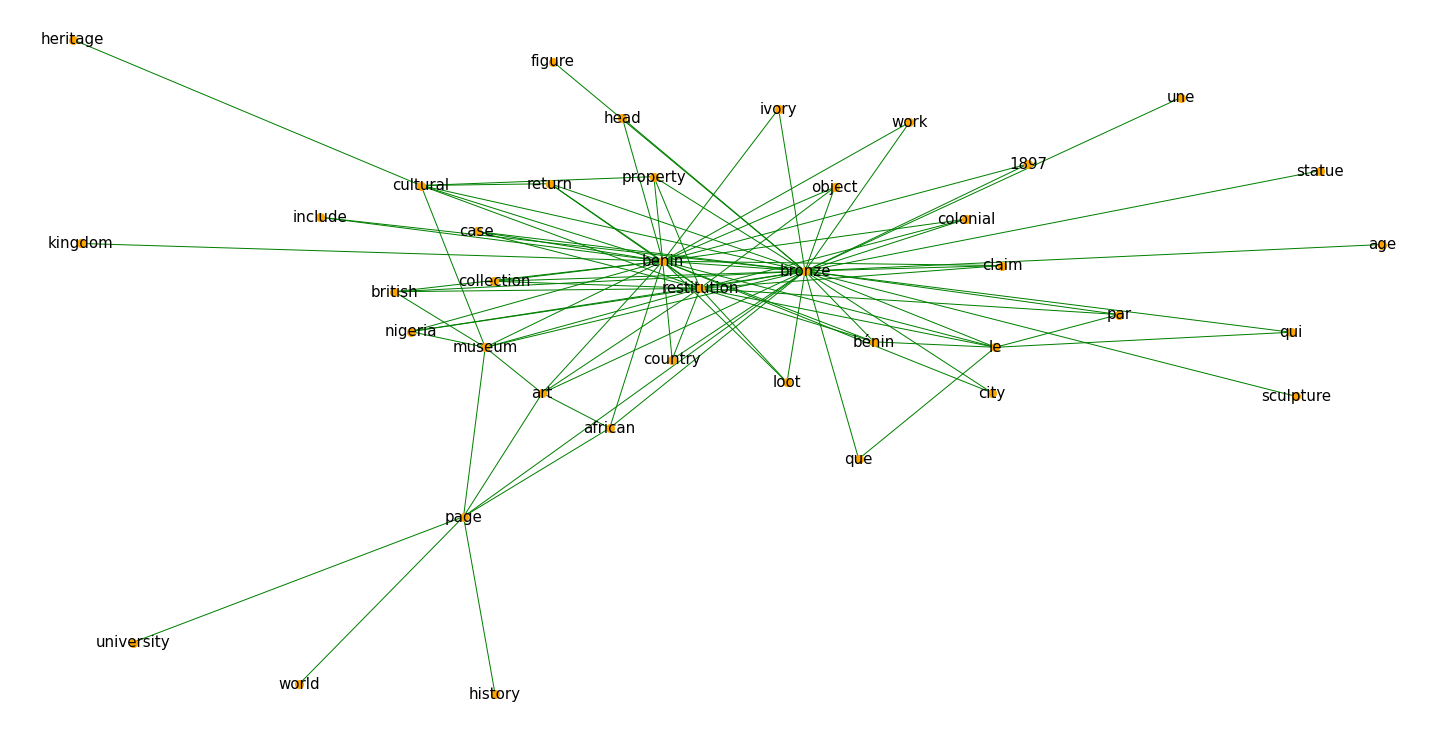

In [270]:
draw_network(df_abs, 'lemma_text', 40) 

In [272]:
from nltk import bigrams

0      article begin discuss change mode display non ...
1      restitution subtraction refuse longer defend i...
2      31 martin 0 akanbiemu dispersal benin work art...
3      would safe judge book cover graphic parody ico...
4      brutish museum dan hick intellectual theoretic...
                             ...                        
988    projets ong ont fait promotion cet arbre haute...
990    page 1 hal id tel 00630661 submit 10 oct 2011 ...
992    page 1 page 2 bogdanka pavelin lešić – darja d...
993    page 1 nicy ures 16 page 2 page 3 1 1166 cant ...
994    page 1 page 2 biogr igen yatis con page 3 page...
Name: lemma_text, Length: 892, dtype: object

In [279]:
list(bigrams(df_abs['lemma_text'][0]))

[('a', 'r'),
 ('r', 't'),
 ('t', 'i'),
 ('i', 'c'),
 ('c', 'l'),
 ('l', 'e'),
 ('e', ' '),
 (' ', 'b'),
 ('b', 'e'),
 ('e', 'g'),
 ('g', 'i'),
 ('i', 'n'),
 ('n', ' '),
 (' ', 'd'),
 ('d', 'i'),
 ('i', 's'),
 ('s', 'c'),
 ('c', 'u'),
 ('u', 's'),
 ('s', 's'),
 ('s', ' '),
 (' ', 'c'),
 ('c', 'h'),
 ('h', 'a'),
 ('a', 'n'),
 ('n', 'g'),
 ('g', 'e'),
 ('e', ' '),
 (' ', 'm'),
 ('m', 'o'),
 ('o', 'd'),
 ('d', 'e'),
 ('e', ' '),
 (' ', 'd'),
 ('d', 'i'),
 ('i', 's'),
 ('s', 'p'),
 ('p', 'l'),
 ('l', 'a'),
 ('a', 'y'),
 ('y', ' '),
 (' ', 'n'),
 ('n', 'o'),
 ('o', 'n'),
 ('n', ' '),
 (' ', 'w'),
 ('w', 'e'),
 ('e', 's'),
 ('s', 't'),
 ('t', 'e'),
 ('e', 'r'),
 ('r', 'n'),
 ('n', ' '),
 (' ', 'v'),
 ('v', 'i'),
 ('i', 's'),
 ('s', 'u'),
 ('u', 'a'),
 ('a', 'l'),
 ('l', ' '),
 (' ', 'c'),
 ('c', 'u'),
 ('u', 'l'),
 ('l', 't'),
 ('t', 'u'),
 ('u', 'r'),
 ('r', 'e'),
 ('e', ' '),
 (' ', 'w'),
 ('w', 'e'),
 ('e', 's'),
 ('s', 't'),
 ('t', 'e'),
 ('e', 'r'),
 ('r', 'n'),
 ('n', ' '),
 (' ', 'm'),

In [275]:
terms_bigram = [list(bigrams(doc)) for doc in df_abs['lemma_text']]

In [276]:
terms_bigram

[[('a', 'r'),
  ('r', 't'),
  ('t', 'i'),
  ('i', 'c'),
  ('c', 'l'),
  ('l', 'e'),
  ('e', ' '),
  (' ', 'b'),
  ('b', 'e'),
  ('e', 'g'),
  ('g', 'i'),
  ('i', 'n'),
  ('n', ' '),
  (' ', 'd'),
  ('d', 'i'),
  ('i', 's'),
  ('s', 'c'),
  ('c', 'u'),
  ('u', 's'),
  ('s', 's'),
  ('s', ' '),
  (' ', 'c'),
  ('c', 'h'),
  ('h', 'a'),
  ('a', 'n'),
  ('n', 'g'),
  ('g', 'e'),
  ('e', ' '),
  (' ', 'm'),
  ('m', 'o'),
  ('o', 'd'),
  ('d', 'e'),
  ('e', ' '),
  (' ', 'd'),
  ('d', 'i'),
  ('i', 's'),
  ('s', 'p'),
  ('p', 'l'),
  ('l', 'a'),
  ('a', 'y'),
  ('y', ' '),
  (' ', 'n'),
  ('n', 'o'),
  ('o', 'n'),
  ('n', ' '),
  (' ', 'w'),
  ('w', 'e'),
  ('e', 's'),
  ('s', 't'),
  ('t', 'e'),
  ('e', 'r'),
  ('r', 'n'),
  ('n', ' '),
  (' ', 'v'),
  ('v', 'i'),
  ('i', 's'),
  ('s', 'u'),
  ('u', 'a'),
  ('a', 'l'),
  ('l', ' '),
  (' ', 'c'),
  ('c', 'u'),
  ('u', 'l'),
  ('l', 't'),
  ('t', 'u'),
  ('u', 'r'),
  ('r', 'e'),
  ('e', ' '),
  (' ', 'w'),
  ('w', 'e'),
  ('e', 's'),
  ('s'

### 3. Peoples vs citations vs ethnicity - CSV list, network diagram

# Media 

In [8]:
df = pd.read_csv('bb_google_content172_cleaned.csv', index_col=0)

### 1. Keywords - Network diagram: Pelonomi

I suspect that the value her is how often the two terms co-occur but I am not sure. It is more likely just the frequency count of the word but then I dont know how they get linked together. I am not sure

In [29]:
print(df.shape)
df_text = df[~df['text'].isna()]
df_text.shape

(172, 7)


(164, 7)

So, we lost a couple of articles because we could not get text from them (their text is NaN)

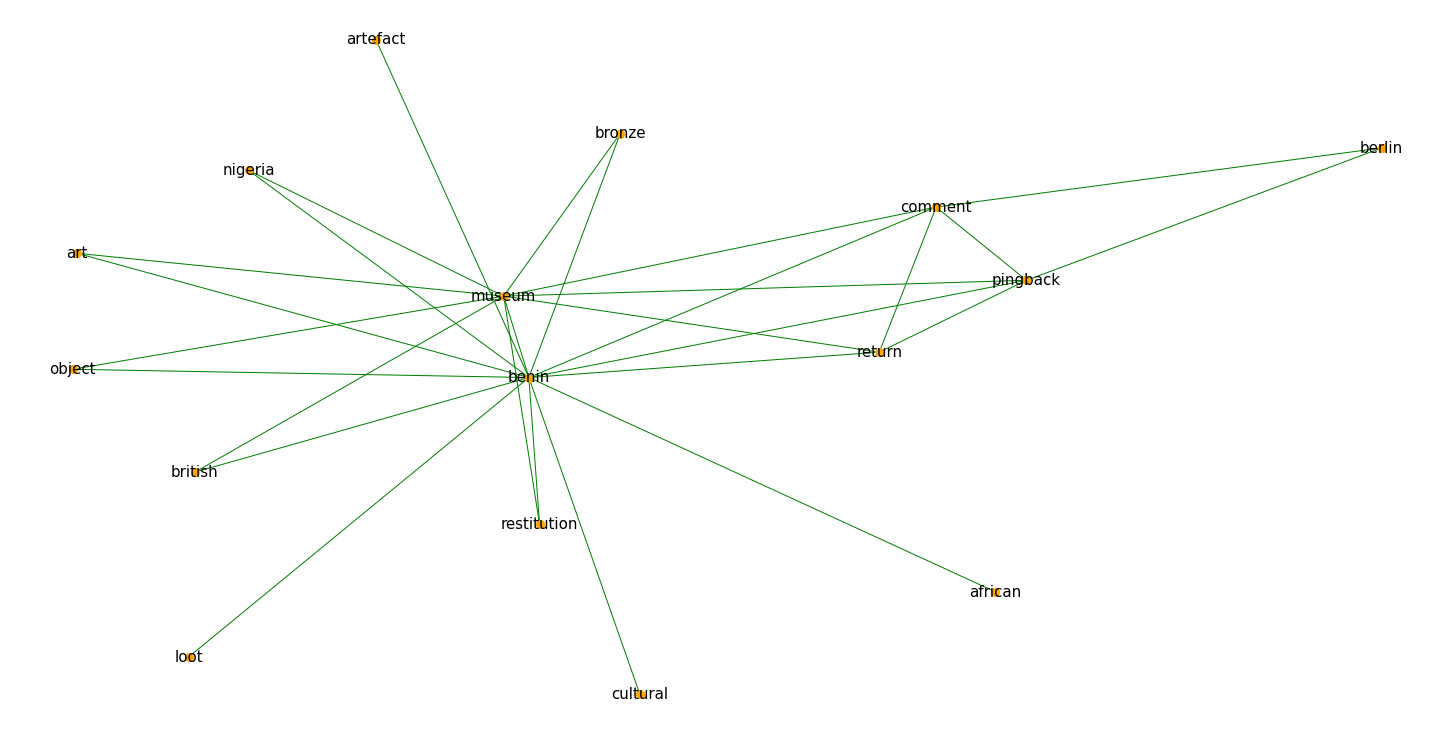

In [82]:
draw_network(df_text, 'lemma_text', 20000) #20000

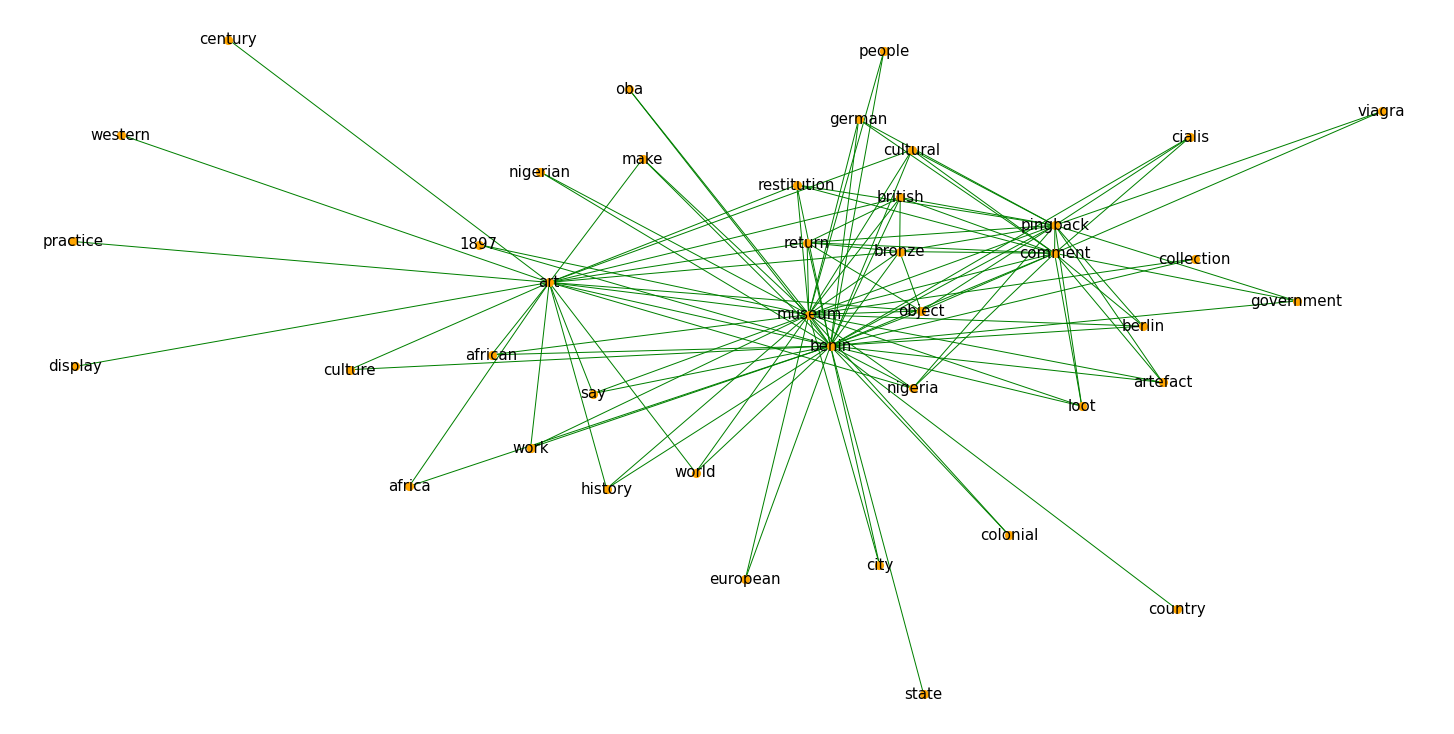

In [84]:
draw_network(df_text, 'lemma_text', 10000) #10000

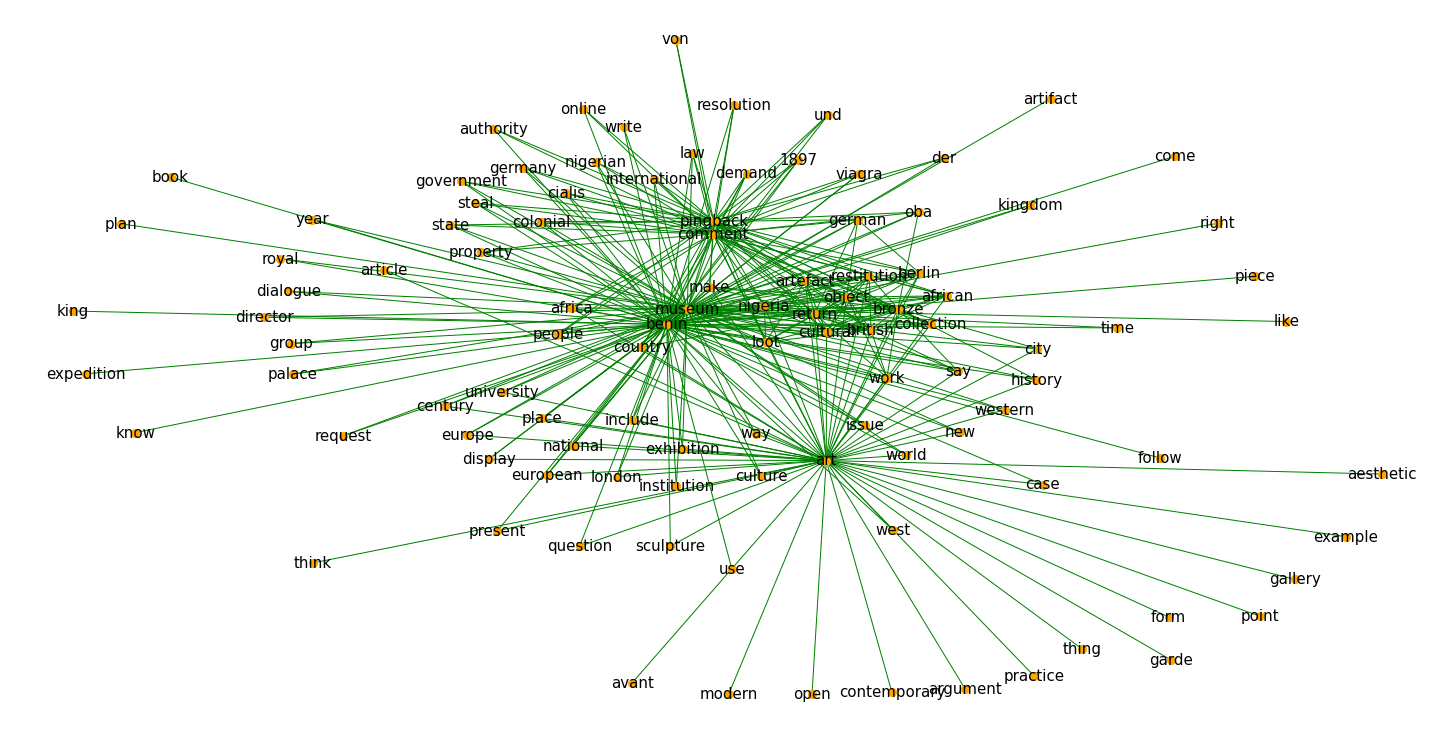

In [271]:
draw_network(df_text, 'lemma_text', 5000) #10000

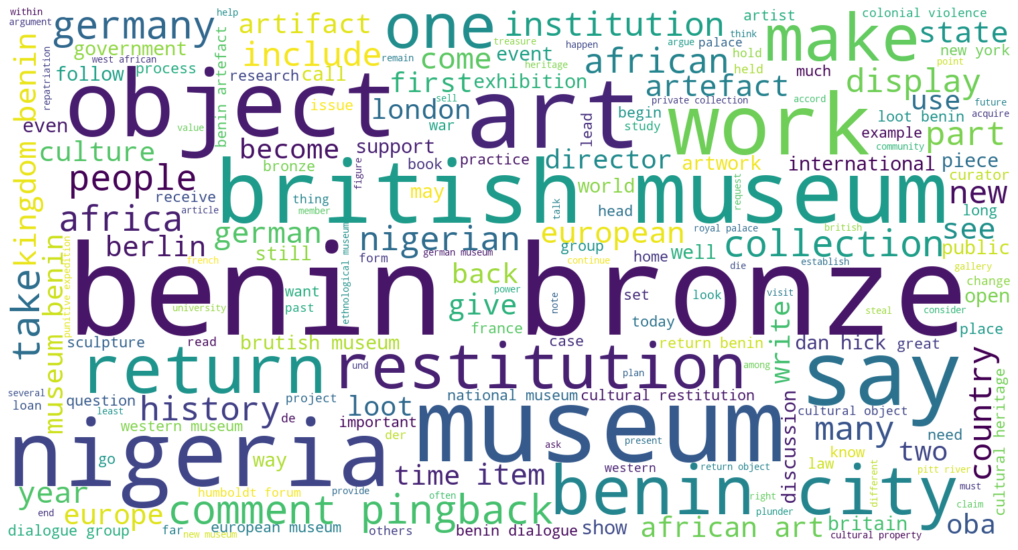

In [80]:
get_wordcloud(df_text, 'lemma_text')

### 2. Peoples vs mentions vs ethnicity - CSV list, bar chart: Pelonomi